## Notebook Summary

This notebook provides a fractional cover product which can be used to represent land cover. 

The basis for this notebook below and the following explanation are from Digital Earth Australia http://geoscienceaustralia.github.io/digitalearthau/notebooks/02_DEA_datasets/Introduction_to_Fractional_Cover.html.

### What is Fractional Cover

The Fractional Cover product was generated using the spectral unmixing algorithm developed by the Joint Remote Sensing Research Program (JRSRP) which used the spectral signature for each pixel to break it up into three fractions, based on field work that determined the spectral characteristics of these fractions. The fractions were retrieved by inverting multiple linear regression estimates and using synthetic endmembers in a constrained non-negative least squares unmixing model.

The green (PV) fraction includes leaves and grass, the non-photosynthetic fraction (NPV) includes branches, dry grass and dead leaf litter, and the bare soil (BS) fraction includes bare soil or rock.

### Fractional Cover Bands

Bare Soil (bare ground, rock, disturbed) (BS): - Bare Ground (bare soil, rock) percentage; Digital Number 10000 = 100%

Photosythetic Vegetation. (green grass, trees, etc.) (PV): - Photosynthetic Vegetation: Green Vegetation percentage;Digital Number 10000 = 100%

Non-Photosythetic vegetation (litter, dead leaf and branches) (NPV): - Non-Photosynthetic Vegetation (litter, dead leaves andbranches) percentage; Digital Number 10000 = 100%

Unmixing Error (UE): - Unmixing Error. The residual error, defined as the Euclidean Norm of the Residual Vector. High values express less confidence in the fractional components.

This notebook builds on the single L8 image with cloud and water mask provided by Digital Earth Austrlia to provide a median product for a time range. This reduces the influence of cloud and variability associated with water identification. 

The product has also been developed to function for Landsat-7, Landsat-5, Landsat-4 and Sentinel-2. 


In [1]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
import numpy as np
import yaml
import rioxarray as rxr
import glob



#from datacube-utilities.dc_fractional_coverage_classifier import frac_coverage_classify

# Import functions to load and stack data without datacube
from notebook_functions import *
from utilities import *

import dask
import dask.array as da
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, memory_limit='7GB')

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45291,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:35395,Total threads: 4
Dashboard: http://127.0.0.1:42173/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:42545,


## Set Up Parameters

In [3]:
# Running locally on landsat 8 data for now
product = 'landsat_8'

# St Maarten bounding box to subset the data
clip_coords = {'min_lon':-63.461424,
               'min_lat': 17.950000,
               'max_lon': -62.80000,
               'max_lat': 18.334848}

# Set size of dask chunks to use for the scenes
dask_chunks = dict(
    x = 1000,
    y = 1000
)

# Set mosaic type (options: 'median', 'mean', 'max', 'min')
mosaic_type = 'median'


measurements = ["blue", "green", "red", "nir", "swir1", "swir2", "pixel_qa"]


#parameter display_name="Water Mask" description="If you would like the water to be masked out choose YES, if you would like the full image choose NO" datatype="string" options=["YES", "NO"],
mask_water = 'YES'


## Load Data

In [4]:
def prep_dataset(in_dir, measurement, product, clip_coords = None):
    """Prepare either the baseline or analysis dataset."""
    scenes = glob.glob(f'{in_dir}/*/')

    array_list = []

    for scene in scenes:
        yml = f'{scene}/datacube-metadata.yaml'
        with open (yml) as stream: yml_meta = yaml.safe_load(stream)

        # Load the bands provided in 'measurement' from the yaml file.
        o_bands_data = [ rxr.open_rasterio(scene + yml_meta['image']['bands'][b]['path'], chunks=dask_chunks) for b in measurement ] 

        # Clip the data to the bounding box if provided.
        if clip_coords is not None:
            o_bands_data = [ o_bands_data[i].rio.clip_box(minx = clip_coords['min_lon'], miny = clip_coords['min_lat'], 
                                                          maxx = clip_coords['max_lon'], maxy = clip_coords['max_lat']) 
                                                          for i in range(len(o_bands_data)) ]

        # Get the timestamp from the yaml file.
        timestamp = datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')

        # Stack the bands together into a single xarray dataset.
        band_data = stack_bands(o_bands_data, measurement, timestamp)

        # Append each stacked scene to a list to be combined later.
        array_list.append(band_data)

    # Stack the scenes together into xarray dataset.
    ds = stack_scenes(array_list)

    # Mask out nodata values.
    ds = ds.where(ds != -9999)
    print(f'Final Dataset: {ds}')

    return ds

In [5]:
# Running on data from St Maarten
dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat/'
ds = prep_dataset(dir, measurements, product, clip_coords)


Final Dataset: <xarray.Dataset>
Dimensions:      (time: 7, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2018-09-06 2022-11-20 ... 2018-03-14
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000),

## Cloud Masking

In [34]:
# Generate cloud mask
#clean_mask = ls_cloud_mask(ds)
clean_mask = ls_clean_mask(ds, keep_water=False)

## Generate Geomedian

In [35]:
from odc.algo import xr_geomedian, to_rgba, to_f32
from odc.ui import to_png_data
#import hdstats

# Drop the pixel_qa band from the dataset
ds_analysis = ds.drop(['pixel_qa'])

ds_clean = ds_analysis.where(clean_mask == 1, np.nan)

scale, offset = (1, 0)

ds_clean_32 = to_f32(ds_clean, scale=scale, offset=offset)

yy = xr_geomedian(ds_clean_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  #axis='time',
                  eps=0.2*(1/10_000),  # 1/5 pixel value resolution
                  nocheck=True) 

yy

<xarray.Dataset>
Dimensions:  (y: 1429, x: 2455)
Coordinates:
  * y        (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * x        (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8 -62.8
Data variables:
    blue     (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    green    (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    red      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    nir      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    swir1    (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    swir2    (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

### Visualise Geomedian

In [36]:
def normalize_0_1(band):
    """Normalize band ranges between 0 and 1 for image display purposes."""
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

def gammacorr(band):
    """Apply gamma correction to the band (brightens image)."""
    gamma=2
    return np.power(band, 1/gamma)


red_g = gammacorr(yy.red)
green_g = gammacorr(yy.green)
blue_g = gammacorr(yy.blue)


red_n = normalize_0_1(red_g)
green_n = normalize_0_1(green_g)
blue_n = normalize_0_1(blue_g)

rgb_stack = np.dstack((red_n, green_n, blue_n))

/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty s

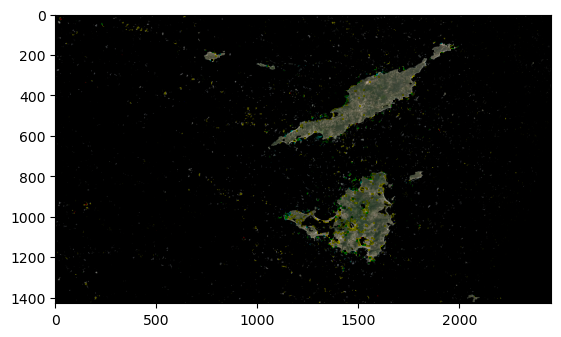

In [37]:
plt.imshow(rgb_stack)

## Fractional Cover from Geomedian

In [38]:
# Rename x to latitude and y to longitude 
yy = yy.rename({'x':'longitude', 'y':'latitude'})

# Run fractional cover classifier on the geomedian dataset
frac_classes = frac_coverage_classify(yy)

/home/spatialdays/Documents/product-notebooks/AncillaryData/endmembers_landsat.csv


/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty slice
  lambda x: nangeomedian_pcm(x, **kw),
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/odc/algo/_geomedian.py:99: RuntimeWarning: Mean of empty s

### Visualise Fractional Cover

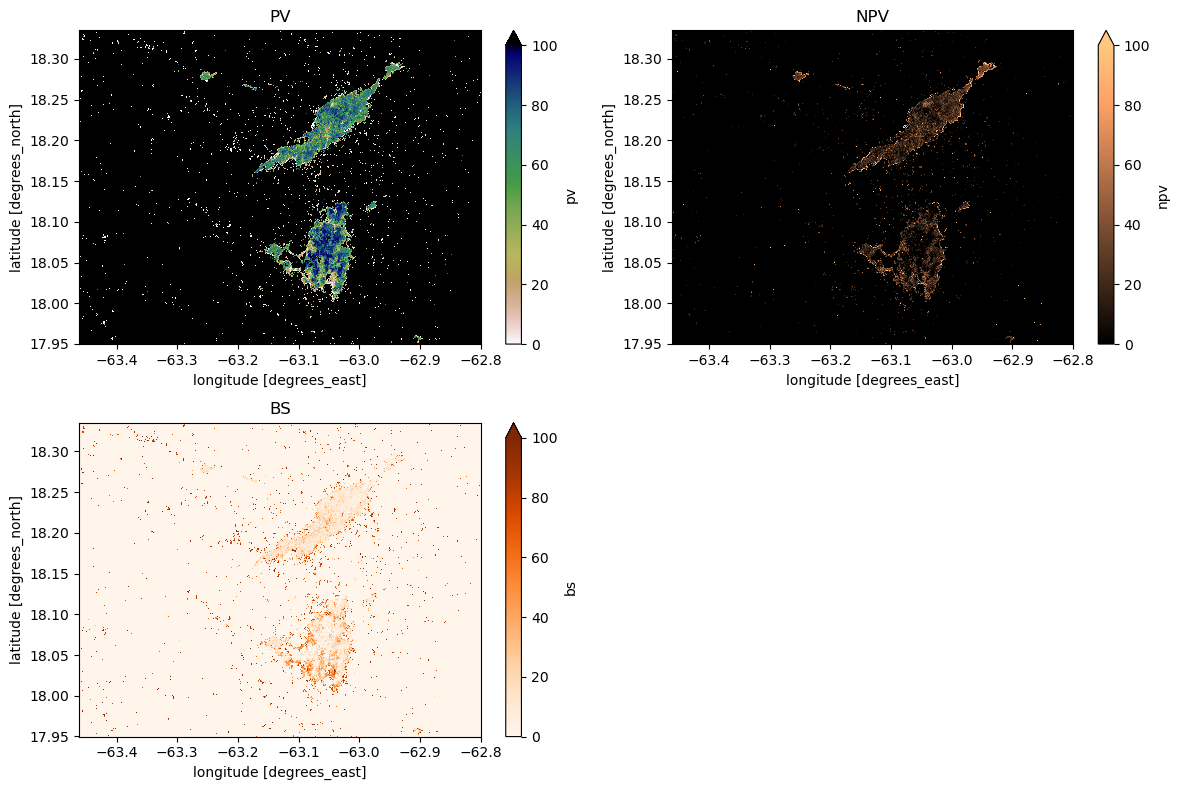

In [39]:
import matplotlib.gridspec as gridspec

# jupyteronly
#plot the fractional cover bands. 
scene = 0
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2) # set up a 2 x 2 grid of 4 images for better presentation

ax1=plt.subplot(gs[0,0])
frac_classes.pv.plot(cmap='gist_earth_r', vmin = 0, vmax = 100)
ax1.set_title('PV')

ax2=plt.subplot(gs[1,0])
frac_classes.bs.plot(cmap='Oranges', vmin = 0, vmax = 100)
ax2.set_title('BS')

ax3=plt.subplot(gs[0,1])
frac_classes.npv.plot(cmap='copper', vmin = 0, vmax = 100)
ax3.set_title('NPV')

plt.tight_layout()
plt.show()